<a href="https://colab.research.google.com/github/hughesymendes/MandelbrotSet/blob/master/AllDips.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lightkurve

!pip install exoplanet

!pip install pymc3==3.8

!pip install corner



/usr/local/lib/python3.6/dist-packages/lightkurve/search.py:233: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning)


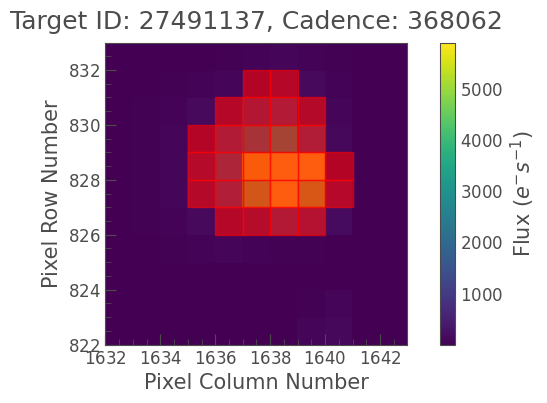

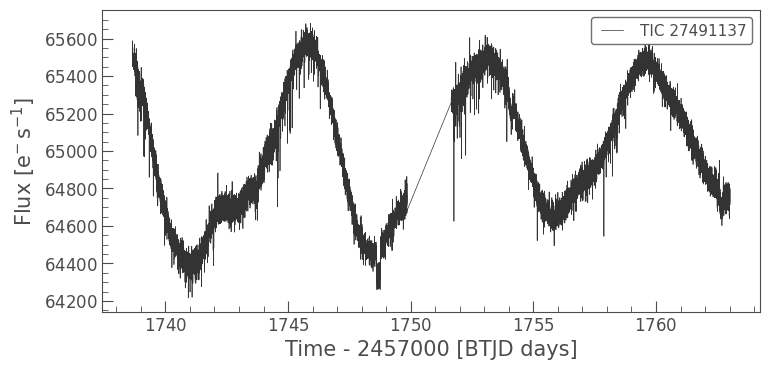

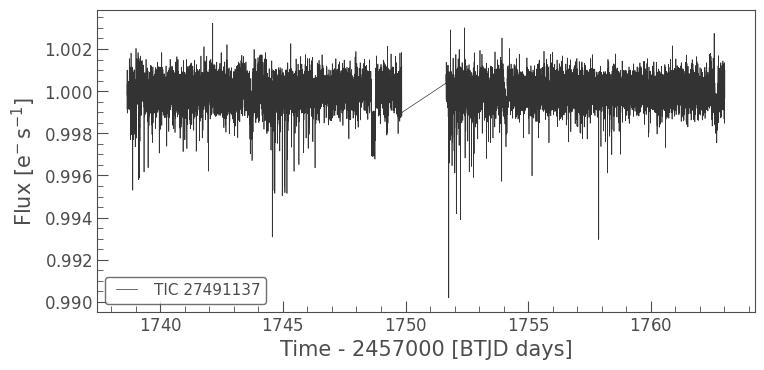

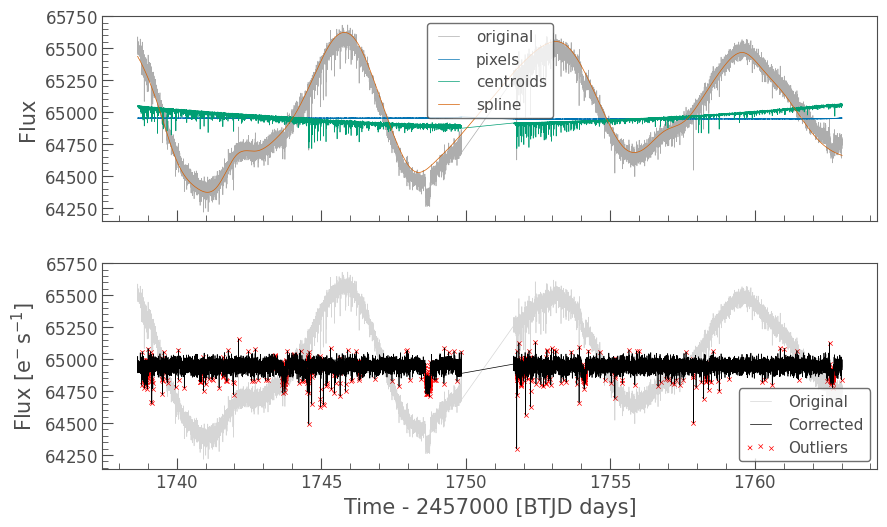

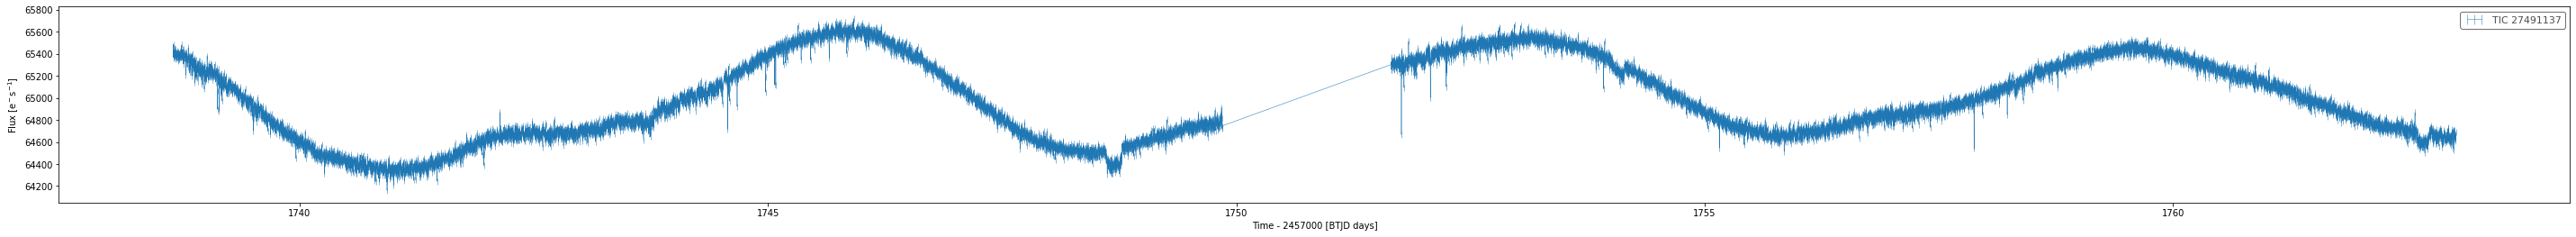

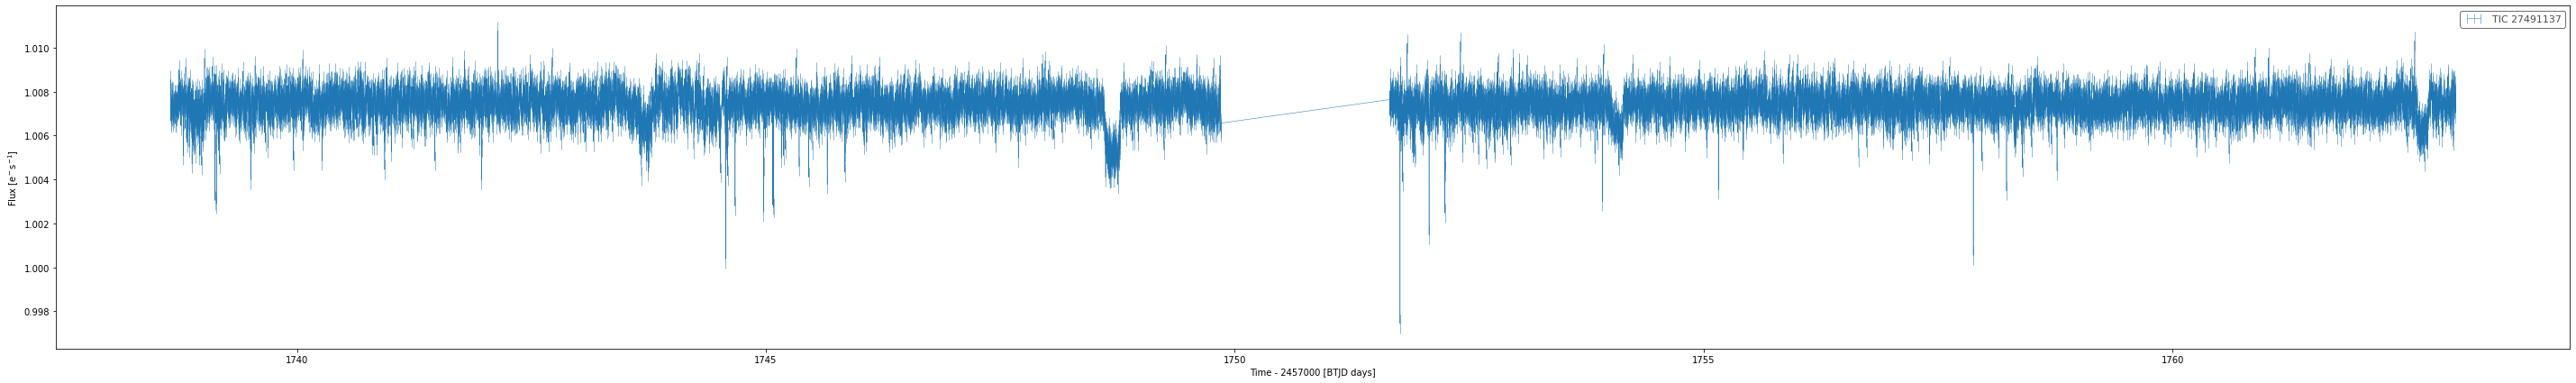

In [2]:
import lightkurve as lk
from lightkurve import search_targetpixelfile
from lightkurve import TessTargetPixelFile
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#downloading data from MAST
tpf = search_targetpixelfile("TIC 27491137").download()
aper = tpf.create_threshold_mask()
tpf.plot(aperture_mask = aper, mask_color = "red")

#Creating Lightcurve from TPF
lc = tpf.to_lightcurve()

#Masking out Argabrightening events
mask = np.isfinite(lc.flux_err)
clipped = lc[mask]

clipped.plot()

flc = clipped.flatten(window_length = 1001).plot()

pixels = tpf.flux[mask][:, ~aper]
dm1 = lk.DesignMatrix(pixels, name='pixels').pca(3).append_constant()

# We'll do a 3D low order polynomial in TIME, COLUMN CENTROID and ROW CENTROID:

r, c = tpf[mask].estimate_centroids()
r, c = r - np.median(r), c - np.median(c)


t = (lc[mask].cadenceno - np.median(lc.cadenceno))/(len(lc.time))


dm2 = lk.DesignMatrix(np.vstack([r, c, r*c, r**2, c**2, r**2*c, c**2*r, r**2*c**2,
                                t*r, t*c, t*r*c, t*r**2, t*c**2, t*r**2*c, t*c**2*r, t*r**2*c**2]).T, name='centroids')

spline = lk.designmatrix.create_spline_matrix(lc[mask].time, n_knots=35)

dm = lk.DesignMatrixCollection([dm1, dm2, spline])

# Make a very hacky cadence mask:
b = lc[mask].flatten(1001).bin(10)
_, m = b.remove_outliers(3, return_mask=True)
cadence_mask = np.interp(lc[mask].time, b.time, m) != 0

#Tried to make a mask by adding all the areas that i wanted to mask, however it errored out saying needed to be 2D?
#mask = (clipped[3300:3900], clipped[7100:7350], clipped[9500:10000], clipped[15700:]) = True

r = lk.RegressionCorrector(lc[mask])
r.correct(dm, sigma=3., cadence_mask=~cadence_mask)

r.diagnose()

# Remove INSTRUMENT systematics
corr = (r.diagnostic_lightcurves['pixels'] + r.diagnostic_lightcurves['centroids']).flux
corr -= np.median(corr)
clc = (lc[mask] - corr)

fig, ax = plt.subplots(figsize=(50, 4))
(clc).errorbar(ls='-', ax=ax)

# Divide through by STELLAR flux
stellar_flux = r.diagnostic_lightcurves['spline'].flux + np.median(clc.flux)

fig, ax = plt.subplots(figsize=(50, 7))
(clc/stellar_flux).errorbar(ls='-', ax=ax)

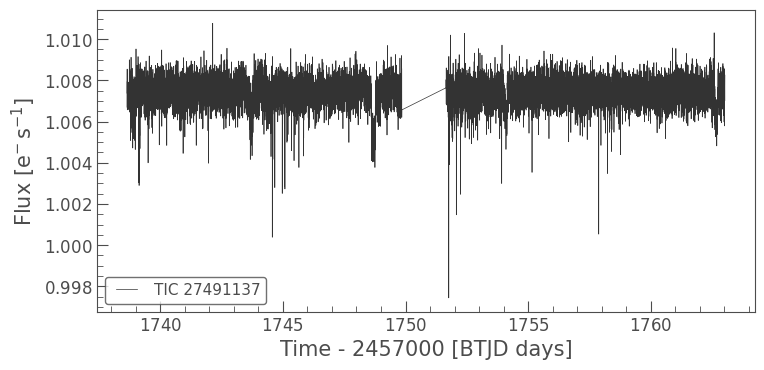

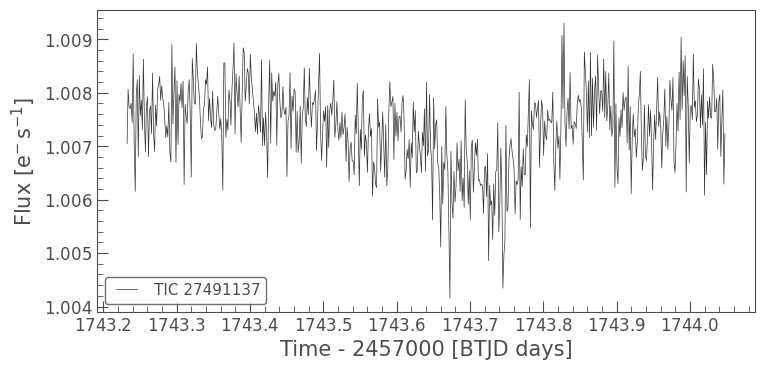

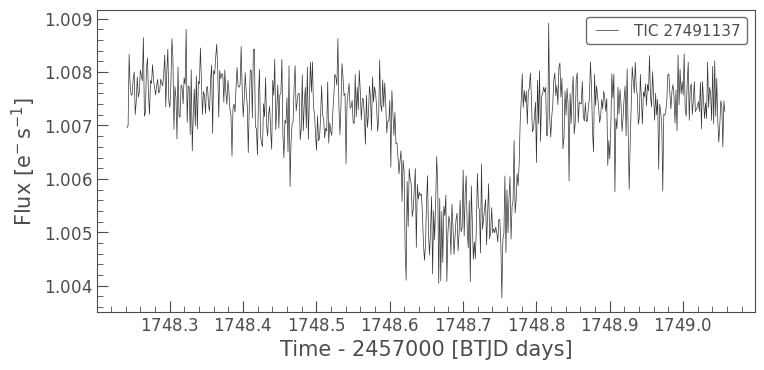

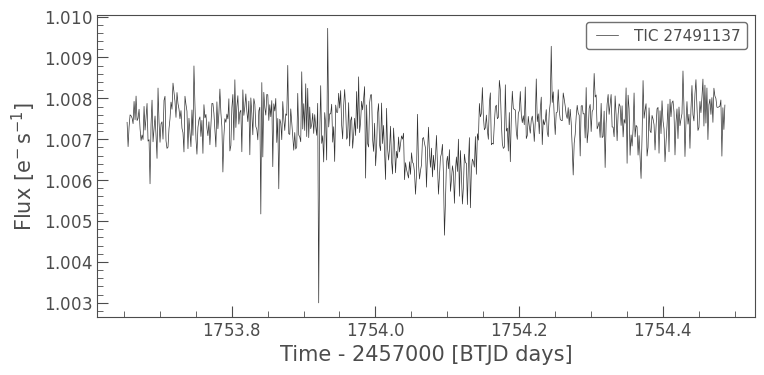

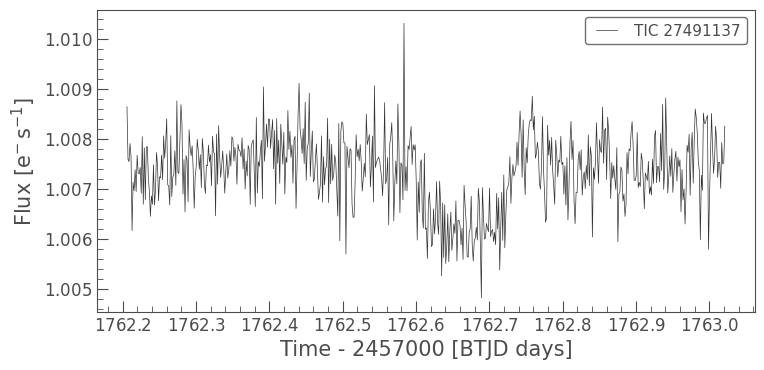

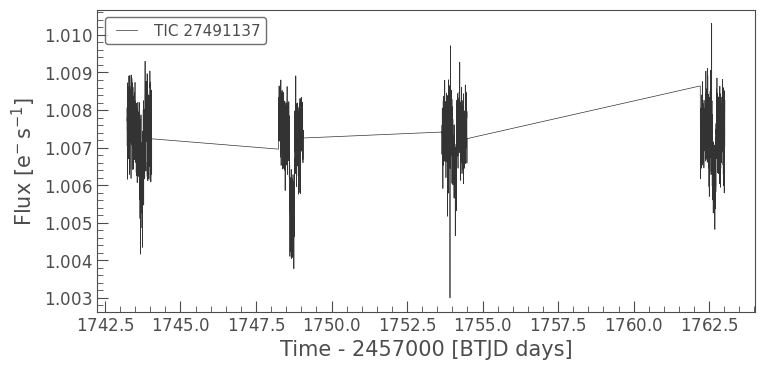

In [3]:
clean_lc = (clc/stellar_flux)
clean_lc.plot()


#IMPORTANT THAT THE ARRAY SIZES FOR THE BELOW DIPS AREN'T CHANGED AS IT WILL AFFECT THE ACCURACY
#OF THE FULL MASKED LC AT THE BOTTOM OF THE CELL. ANY CHANGES IN INDIVIDUAL DIP ARRAY SIZE NEEDS TO BE 
#REFLECTED IN THE MASKING OF THE "AllDips" LC. 



#DIP 1
dip1 = clean_lc[3300:3888]
dip1.plot()

d1x = np.append( np.array( [], dtype="float64" ),dip1.time )
d1y = np.append( np.array( [], dtype="float64" ), dip1.flux - 1.0075 )
d1y_err = np.append( np.array( [], dtype="float64" ), dip1.flux_err )

#DIP 2
dip2 = clean_lc[6900:7488]
dip2.plot()

d2x = np.append( np.array( [], dtype="float64" ),dip2.time )
d2y = np.append( np.array( [], dtype="float64" ), dip2.flux - 1.0075 )
d2y_err = np.append( np.array( [], dtype="float64" ), dip2.flux_err )

#DIP 3
dip3 = clean_lc[9500:10100]
dip3.plot()

d3x = np.append( np.array( [], dtype="float64" ),dip3.time )
d3y = np.append( np.array( [], dtype="float64" ), dip3.flux - 1.0075 )
d3y_err = np.append( np.array( [], dtype="float64" ), dip3.flux_err )

#DIP 4
dip4 = clean_lc[15650:]
dip4.plot()

d4x = np.append( np.array( [], dtype="float64" ),dip4.time )
d4y = np.append( np.array( [], dtype="float64" ), dip4.flux - 1.0075 )
d4y_err = np.append( np.array( [], dtype="float64" ), dip4.flux_err )


#CREATING A MASKED LC SHOWING JUST THE TRANSITS ABOVE
mask1 = (clean_lc.time < 1738.64923721) | (clean_lc.time > 1743.23244862) 
m1lc = clean_lc[mask1]
mask2 = (m1lc.time < 1744.04770813) | (m1lc.time > 1748.24207156) 
m2lc =  m1lc[mask2]
mask3 = (m2lc.time < 1749.0573360) | (m2lc.time > 1753.65447995) 
m3lc = m2lc[mask3]
mask4 = (m3lc.time < 1754.48641353) | (m3lc.time > 1762.20580501) 
AllDips = m3lc[mask4]
AllDips.plot()

ADx = np.append( np.array( [], dtype="float64" ),AllDips.time )
ADy = np.append( np.array( [], dtype="float64" ), AllDips.flux - 1.0075 )
ADy_err = np.append( np.array( [], dtype="float64" ), AllDips.flux_err )

In [0]:
d1x,d2x,d3x,d4x

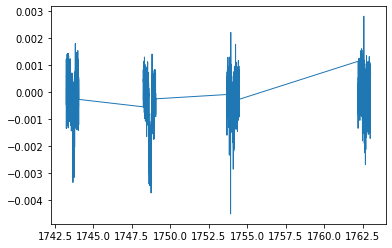

In [0]:
plt.plot(ADx, ADy, color="C0", lw=1)


/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
optimizing logp for variables: [r]


/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Optimization terminated successfully.
logp: 13253.502226287397 -> 13396.363212478329


optimizing logp for variables: [t0]


/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


message: Optimization terminated successfully.
logp: 13396.363212478329 -> 13456.979371833006
optimizing logp for variables: [u]


/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


message: Optimization terminated successfully.
logp: 13456.979371833006 -> 13471.041836368058
optimizing logp for variables: [b, r, u, period, t0, mean, m_star, r_star]


/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this wil

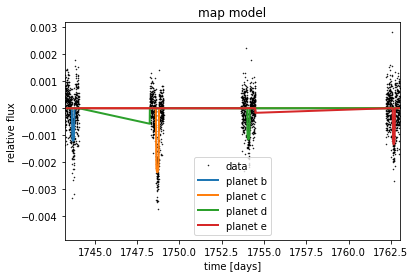

In [4]:
import pymc3 as pm
import exoplanet as xo
import pickle as pk

with pm.Model() as model:

    #defining vars
    r_star = pm.Normal("r_star", mu=0.772148, sd= 0.0454673,testval= 0.78)

    
    m_star = pm.Normal("m_star", mu=0.87, sd=0.108032, testval= 0.87)


    # The baseline flux
    mean = pm.Normal("mean", mu=0, sd=0.0001)

    # The time of a reference transit for each planet
    t0 = pm.Normal("t0", mu=np.array([1743.72, 1748.69, 1754.075, 1762.67]), sd=0.01, shape=4)

    # creating a large uniform distribution for the period
    #logP = pm.Uniform("logp", lower=0, upper=2, testval=1, shape = 4)

    # TestVals chosen as delta(t) for dip1-3 is 10.355days whereas delta(t) for dip3-4 is 8.595 days
    #large dip only occurs once in sector too which is 27 days in length so period should be > 27 days
    period = pm.Uniform("period", lower=1, upper=1500, testval=np.array([8, 27, 8, 8]), shape = 4)
   

    # The Kipping (2013) parameterization for quadratic limb darkening paramters
    #Values for 5000k and 5250k taken from http://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=J/A%2bA/529/A75/table-af
    #and then an value calculated using the given Stellar temp from ExoFOP 

    # calculated values were a=0.2141 b=0.3795 but it seems to work better in the test val as[b,a]???
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.3795, 0.2141]))

    #r is in units of R_star which is units of R_sun
    #r needs to encompass all possible radii for the 4 transits
    r = pm.Uniform("r", lower=0.02, upper=0.7, shape= 4, testval=np.array([0.03, 0.04, 0.03, 0.03]))
    b = xo.distributions.ImpactParameter("b", ror=r/r_star, shape= 4, testval=np.random.rand(4))


    # Set up a Keplerian orbit for the planets
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b, r_star=r_star, m_star=m_star)

    # Compute a limb-darkened light curve using starry
    t = ADx

    # Compute the model light curve using starry
    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=r, t=t)
    light_curve = pm.math.sum(light_curves, axis=-1) + mean

    # Here we track the value of the model light curve for plotting
    # purposes
    pm.Deterministic("light_curves", light_curves)

    #Actual dataset
    y = ADy

    # The likelihood function assuming known Gaussian uncertainty- 
    #Likelihood function is a function that represents the distribution from an actual test sample
    pm.Normal("obs", mu=light_curve, sd=ADy_err, observed=y)

    # Fit for the maximum a posteriori parameters given the simuated dataset
    # Posterior distribution is usually given as Prior*Likelihood
    map_soln = xo.optimize(start=model.test_point, vars=[r])
    map_soln = xo.optimize(start=map_soln, vars=[t0])
    map_soln = xo.optimize(start=map_soln, vars=[u])
    map_soln = xo.optimize(start=map_soln)


ModelPlot = plt.figure()
plt.plot(t, y, ".k", ms=1, label="data")
for i, l in enumerate("bcde"):
    plt.plot(t, map_soln["light_curves"][:, i], lw=2, label="planet {0}".format(l))
plt.xlim(t.min(), t.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
_ = plt.title("map model")

### SKIP SAMPLING AND PLOTTING CORNERS TO RUN EACH TRANSIT SEPERATELY FIRST AS CHECK FOR GOOD FIT. CODE BELOW

In [0]:
np.random.seed(42)
with model:
    trace = pm.sample(
        tune=3000,
        draws=2000,
        start=map_soln,
        chains=4,
        step=xo.get_dense_nuts_step(target_accept=0.9),
    )

pm.summary(trace, varnames=["period", "t0", "r", "b", "u", "r_star", "m_star"])




/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Sequential sampling (4 chains in 1 job)
NUTS: [b, r, u, period, t0, mean, m_star, r_star]
Sampling chain 0, 0 divergences:   0%|          | 0/5000 [00:00<?, ?it/s]

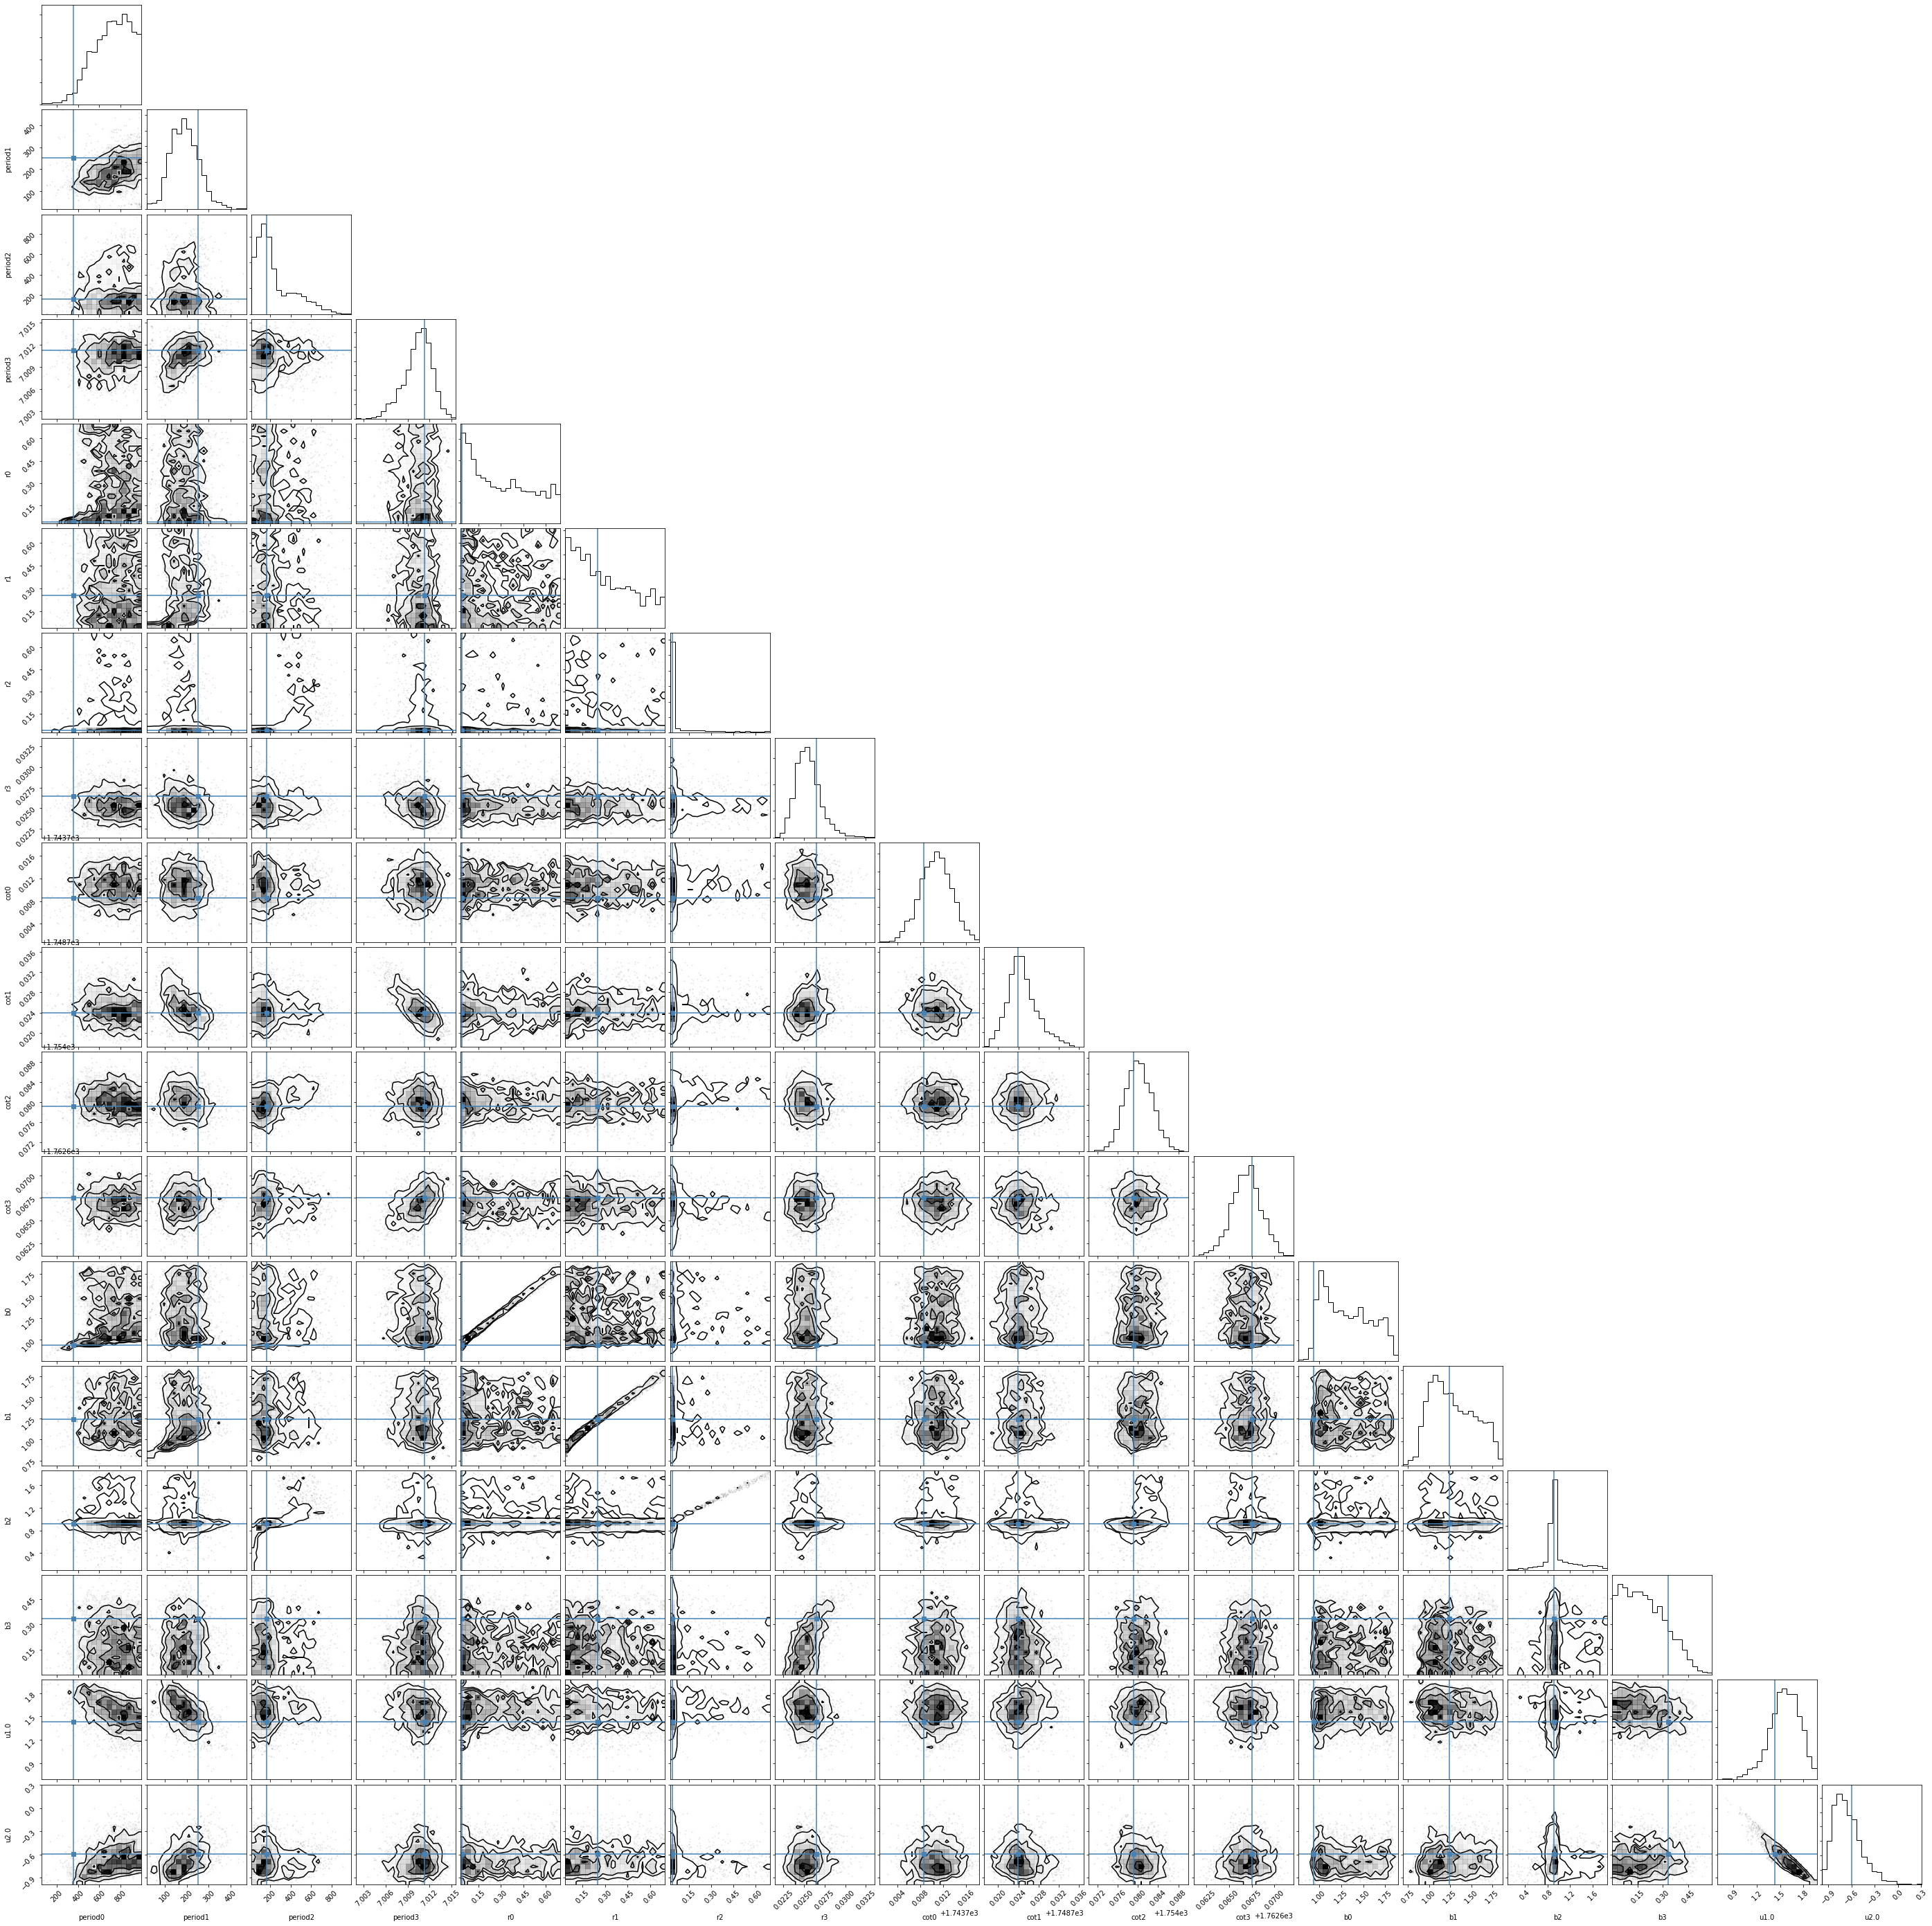

In [10]:
import corner
#double clicking the resulting image will zoom in
samples = pm.trace_to_dataframe(trace, varnames=["period", "r", "t0", "b", "u"])
truth = np.concatenate(xo.eval_in_model([period, r, t0, b, u], map_soln, model=model))
corner.corner(
    samples, truths=truth, labels=["period0","period1", "period2", "period3", "r0", "r1", "r2", "r3", "cot0", "cot1", "cot2", "cot3", "b0", "b1", "b2", "b3", "u1.0", "u2.0", "u1.1", "u2.1", "u1.2", "u2.2", "u1.3",  "u2.3"  ]
);



### **BELOW IS WHERE WE ARE SAVING THE OUTPUTS TO FILE**


In [0]:
from google.colab import files

#MAP_SOLN
filename = "ModelPlot.pickle"
outfile = open(filename, "wb")
pk.dump(ModelPlot, outfile)
outfile.close()
files.download('ModelPlot.pickle')

#TRACE
filename = "Trace.pickle"
outfile = open(filename, "wb")
pk.dump(trace, outfile)
outfile.close()
files.download('Trace.pickle')

#CORNERPLOT
filename = "CornerPlot.pickle"
outfile = open(filename, "wb")
pk.dump(corner, outfile)
outfile.close()
files.download('CornerPlot.pickle')

### CODE FOR EACH TRANSITS FIT. **ENSURE ANY CHANGED VARIABLES IN MODEL ARE MIRRORED HERE**

/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
optimizing logp for variables: [r]


/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


message: Optimization terminated successfully.
logp: 3291.204618674545 -> 3299.908637775068
optimizing logp for variables: [t0]


/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


message: Optimization terminated successfully.
logp: 3299.908637775068 -> 3319.474675666358
optimizing logp for variables: [u]


message: Optimization terminated successfully.
logp: 3319.474675666358 -> 3329.121308994146
optimizing logp for variables: [b, r, u, period, t0, mean, m_star, r_star]


/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this wil

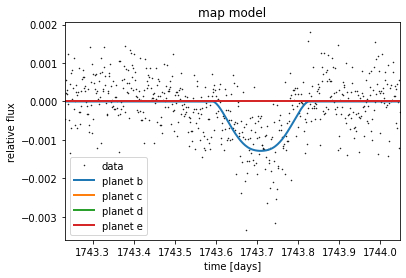

In [6]:
#RUNNING FOR DIP 1

with pm.Model() as model:
    #defining vars
    r_star = pm.Normal("r_star", mu=0.772148, sd= 0.0454673,testval= 0.78)

    
    m_star = pm.Normal("m_star", mu=0.87, sd=0.108032, testval= 0.87)


    # The baseline flux
    mean = pm.Normal("mean", mu=0, sd=0.0001)

    # The time of a reference transit for each planet
    t0 = pm.Normal("t0", mu=np.array([1743.72, 1748.69, 1754.075, 1762.67]), sd=0.01, shape=4)

    # creating a large uniform distribution for the period
    #logP = pm.Uniform("logp", lower=0, upper=2, testval=1, shape = 4)

    # TestVals chosen as delta(t) for dip1-3 is 10.355days whereas delta(t) for dip3-4 is 8.595 days
    #large dip only occurs once in sector too which is 27 days in length so period should be > 27 days
    period = pm.Uniform("period", lower=0, upper=1500, testval=np.array([8, 27, 8, 8]), shape = 4)
   

    # The Kipping (2013) parameterization for quadratic limb darkening paramters
    #https://arxiv.org/pdf/0912.2274.pdf <-- paper used to estimate values
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.3795, 0.2141]))

    #r is in units of R_star which is units of R_sun
    #r needs to encompass all possible radii for the 4 transits
    r = pm.Uniform("r", lower=0.02, upper=0.10, shape= 4, testval=np.array([0.03, 0.04, 0.03, 0.03]))
    b = xo.distributions.ImpactParameter("b", ror=r/r_star, shape= 4, testval=np.random.rand(4))


    # Set up a Keplerian orbit for the planets
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b, r_star=r_star, m_star=m_star)

    # Compute a limb-darkened light curve using starry
    t = d1x

    # Compute the model light curve using starry
    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=r, t=t)
    light_curve = pm.math.sum(light_curves, axis=-1) + mean

    # Here we track the value of the model light curve for plotting
    # purposes
    pm.Deterministic("light_curves", light_curves)

    #Actual dataset
    y = d1y

    # The likelihood function assuming known Gaussian uncertainty- 
    #Likelihood function is a function that represents the distribution from an actual test sample
    pm.Normal("obs", mu=light_curve, sd=d1y_err, observed=y)

    # Fit for the maximum a posteriori parameters given the simuated dataset
    # Posterior distribution is usually given as Prior*Likelihood
    map_soln = xo.optimize(start=model.test_point, vars=[r])
    map_soln = xo.optimize(start=map_soln, vars=[t0])
    map_soln = xo.optimize(start=map_soln, vars=[u])
    map_soln = xo.optimize(start=map_soln)


Dip1Plot = plt.figure()
plt.plot(t, y, ".k", ms=1, label="data")
for i, l in enumerate("bcde"):
    plt.plot(t, map_soln["light_curves"][:, i], lw=2, label="planet {0}".format(l))
plt.xlim(t.min(), t.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
_ = plt.title("map model")

/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
optimizing logp for variables: [r]


message: Optimization terminated successfully.
logp: 3348.0790465975424 -> 3556.215004610449
optimizing logp for variables: [t0]


message: Optimization terminated successfully.
logp: 3556.215004610449 -> 3556.2499672662148
optimizing logp for variables: [u]


message: Optimization terminated successfully.
logp: 3556.2499672662148 -> 3570.833890907229
optimizing logp for variables: [b, r, u, period, t0, mean, m_star, r_star]


/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 3570.833890907229 -> 3613.264250478658


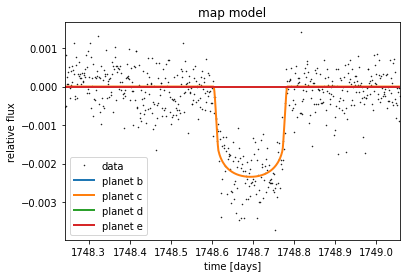

In [7]:
#RUNNING FOR DIP 2


dip2 = clean_lc[6900:7488]

d2x = np.append( np.array( [], dtype="float64" ),dip2.time )
d2y = np.append( np.array( [], dtype="float64" ), dip2.flux - 1.0075 )
d2y_err = np.append( np.array( [], dtype="float64" ), dip2.flux_err )

#Running full model over just dip 2

with pm.Model() as model:
    #defining vars
    r_star = pm.Normal("r_star", mu=0.772148, sd= 0.0454673,testval= 0.78)

    
    m_star = pm.Normal("m_star", mu=0.87, sd=0.108032, testval= 0.87)


    # The baseline flux
    mean = pm.Normal("mean", mu=0, sd=0.0001)

    # The time of a reference transit for each planet
    t0 = pm.Normal("t0", mu=np.array([1743.72, 1748.69, 1754.075, 1762.67]), sd=0.01, shape=4)

    # creating a large uniform distribution for the period
    #logP = pm.Uniform("logp", lower=0, upper=2, testval=1, shape = 4)

    # TestVals chosen as delta(t) for dip1-3 is 10.355days whereas delta(t) for dip3-4 is 8.595 days
    #large dip only occurs once in sector too which is 27 days in length so period should be > 27 days
    period = pm.Uniform("period", lower=0, upper=1500, testval=np.array([8, 27, 8, 8]), shape = 4)
   

    # The Kipping (2013) parameterization for quadratic limb darkening paramters
    #https://arxiv.org/pdf/0912.2274.pdf <-- paper used to estimate values
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.3795, 0.2141]))

    #r is in units of R_star which is units of R_sun
    #r needs to encompass all possible radii for the 4 transits
    r = pm.Uniform("r", lower=0.02, upper=0.10, shape= 4, testval=np.array([0.03, 0.04, 0.03, 0.03]))
    b = xo.distributions.ImpactParameter("b", ror=r/r_star, shape= 4, testval=np.random.rand(4))


    # Set up a Keplerian orbit for the planets
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b, r_star=r_star, m_star=m_star)

    # Compute a limb-darkened light curve using starry
    t = d2x

    # Compute the model light curve using starry
    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=r, t=t)
    light_curve = pm.math.sum(light_curves, axis=-1) + mean

    # Here we track the value of the model light curve for plotting
    # purposes
    pm.Deterministic("light_curves", light_curves)

    #Actual dataset
    y = d2y

    # The likelihood function assuming known Gaussian uncertainty- 
    #Likelihood function is a function that represents the distribution from an actual test sample
    pm.Normal("obs", mu=light_curve, sd=d2y_err, observed=y)

    # Fit for the maximum a posteriori parameters given the simuated dataset
    # Posterior distribution is usually given as Prior*Likelihood
    map_soln = xo.optimize(start=model.test_point, vars=[r])
    map_soln = xo.optimize(start=map_soln, vars=[t0])
    map_soln = xo.optimize(start=map_soln, vars=[u])
    map_soln = xo.optimize(start=map_soln)


Dip2Plot = plt.figure()
plt.plot(t, y, ".k", ms=1, label="data")
for i, l in enumerate("bcde"):
    plt.plot(t, map_soln["light_curves"][:, i], lw=2, label="planet {0}".format(l))
plt.xlim(t.min(), t.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
_ = plt.title("map model")

/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
optimizing logp for variables: [r]


message: Optimization terminated successfully.
logp: 3492.9515893598505 -> 3509.8103567087546
optimizing logp for variables: [t0]


/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 3509.8103567087546 -> 3537.3459711849378


optimizing logp for variables: [u]


message: Optimization terminated successfully.
logp: 3537.3459711849378 -> 3541.8797146904653
optimizing logp for variables: [b, r, u, period, t0, mean, m_star, r_star]


/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 3541.8797146904653 -> 3604.9487545856855


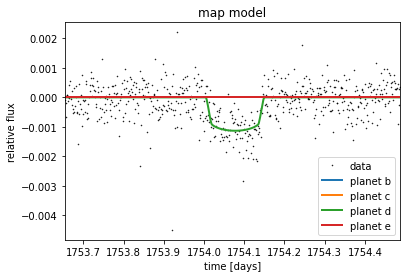

In [8]:
#RUNNING FOR DIP 3

with pm.Model() as model:
    #defining vars
    r_star = pm.Normal("r_star", mu=0.772148, sd= 0.0454673,testval= 0.78)

    
    m_star = pm.Normal("m_star", mu=0.87, sd=0.108032, testval= 0.87)


    # The baseline flux
    mean = pm.Normal("mean", mu=0, sd=0.0001)

    # The time of a reference transit for each planet
    t0 = pm.Normal("t0", mu=np.array([1743.72, 1748.69, 1754.075, 1762.67]), sd=0.01, shape=4)

    # creating a large uniform distribution for the period
    #logP = pm.Uniform("logp", lower=0, upper=2, testval=1, shape = 4)
    
    # TestVals chosen as delta(t) for dip1-3 is 10.355days whereas delta(t) for dip3-4 is 8.595 days
    #large dip only occurs once in sector too which is 27 days in length so period should be > 27 days
    period = pm.Uniform("period", lower=0, upper=1500, testval=np.array([8, 27, 8, 8]), shape = 4)
   

    # The Kipping (2013) parameterization for quadratic limb darkening paramters
    #https://arxiv.org/pdf/0912.2274.pdf <-- paper used to estimate values
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.3795, 0.2141]))

    #r is in units of R_star which is units of R_sun
    #r needs to encompass all possible radii for the 4 transits
    r = pm.Uniform("r", lower=0.02, upper=0.10, shape= 4, testval=np.array([0.03, 0.04, 0.03, 0.03]))
    b = xo.distributions.ImpactParameter("b", ror=r/r_star, shape= 4, testval=np.random.rand(4))


    # Set up a Keplerian orbit for the planets
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b, r_star=r_star, m_star=m_star)

    # Compute a limb-darkened light curve using starry
    t = d3x

    # Compute the model light curve using starry
    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=r, t=t)
    light_curve = pm.math.sum(light_curves, axis=-1) + mean

    # Here we track the value of the model light curve for plotting
    # purposes
    pm.Deterministic("light_curves", light_curves)

    #Actual dataset
    y = d3y

    # The likelihood function assuming known Gaussian uncertainty- 
    #Likelihood function is a function that represents the distribution from an actual test sample
    pm.Normal("obs", mu=light_curve, sd=d3y_err, observed=y)

    # Fit for the maximum a posteriori parameters given the simuated dataset
    # Posterior distribution is usually given as Prior*Likelihood
    map_soln = xo.optimize(start=model.test_point, vars=[r])
    map_soln = xo.optimize(start=map_soln, vars=[t0])
    map_soln = xo.optimize(start=map_soln, vars=[u])
    map_soln = xo.optimize(start=map_soln)


Dip3Plot = plt.figure()
plt.plot(t, y, ".k", ms=1, label="data")
for i, l in enumerate("bcde"):
    plt.plot(t, map_soln["light_curves"][:, i], lw=2, label="planet {0}".format(l))
plt.xlim(t.min(), t.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
_ = plt.title("map model")

/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
optimizing logp for variables: [r]


message: Optimization terminated successfully.
logp: 3342.1892405337803 -> 3347.1811731564007
optimizing logp for variables: [t0]


message: Optimization terminated successfully.
logp: 3347.1811731564007 -> 3351.5241521712596
optimizing logp for variables: [u]


message: Optimization terminated successfully.
logp: 3351.5241521712596 -> 3354.718416395315
optimizing logp for variables: [b, r, u, period, t0, mean, m_star, r_star]


/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this wil

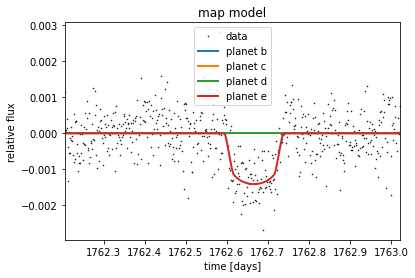

In [9]:
#RUNNING FOR DIP 4

with pm.Model() as model:
    #defining vars
    r_star = pm.Normal("r_star", mu=0.772148, sd= 0.0454673,testval= 0.78)

    
    m_star = pm.Normal("m_star", mu=0.87, sd=0.108032, testval= 0.87)


    # The baseline flux
    mean = pm.Normal("mean", mu=0, sd=0.0001)

    # The time of a reference transit for each planet
    t0 = pm.Normal("t0", mu=np.array([1743.72, 1748.69, 1754.075, 1762.67]), sd=0.01, shape=4)

    # creating a large uniform distribution for the period
    #logP = pm.Uniform("logp", lower=0, upper=2, testval=1, shape = 4)

    # TestVals chosen as delta(t) for dip1-3 is 10.355days whereas delta(t) for dip3-4 is 8.595 days
    #large dip only occurs once in sector too which is 27 days in length so period should be > 27 days
    period = pm.Uniform("period", lower=0, upper=1500, testval=np.array([8, 27, 8, 8]), shape = 4)
   

    # The Kipping (2013) parameterization for quadratic limb darkening paramters
    #https://arxiv.org/pdf/0912.2274.pdf <-- paper used to estimate values
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.3795, 0.2141]))

    #r is in units of R_star which is units of R_sun
    #r needs to encompass all possible radii for the 4 transits
    r = pm.Uniform("r", lower=0.02, upper=0.10, shape= 4, testval=np.array([0.03, 0.04, 0.03, 0.03]))
    b = xo.distributions.ImpactParameter("b", ror=r/r_star, shape= 4, testval=np.random.rand(4))


    # Set up a Keplerian orbit for the planets
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b, r_star=r_star, m_star=m_star)

    # Compute a limb-darkened light curve using starry
    t = d4x

    # Compute the model light curve using starry
    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=r, t=t)
    light_curve = pm.math.sum(light_curves, axis=-1) + mean

    # Here we track the value of the model light curve for plotting
    # purposes
    pm.Deterministic("light_curves", light_curves)

    #Actual dataset
    y = d4y

    # The likelihood function assuming known Gaussian uncertainty- 
    #Likelihood function is a function that represents the distribution from an actual test sample
    pm.Normal("obs", mu=light_curve, sd=d4y_err, observed=y)

    # Fit for the maximum a posteriori parameters given the simuated dataset
    # Posterior distribution is usually given as Prior*Likelihood
    map_soln = xo.optimize(start=model.test_point, vars=[r])
    map_soln = xo.optimize(start=map_soln, vars=[t0])
    map_soln = xo.optimize(start=map_soln, vars=[u])
    map_soln = xo.optimize(start=map_soln)


Dip4Plot = plt.figure()
plt.plot(t, y, ".k", ms=1, label="data")
for i, l in enumerate("bcde"):
    plt.plot(t, map_soln["light_curves"][:, i], lw=2, label="planet {0}".format(l))
plt.xlim(t.min(), t.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
_ = plt.title("map model")